## Hardware Testbed and Large-scale Testbed Co-simulation

## Co-Simulation

In [1]:
# --- imports ---

import os
import subprocess

import time
import logging
logger = logging.getLogger(__name__)

import csv
import time, datetime
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import andes

from andes.utils.misc import elapsed

andes.config_logger(30)

print(andes.__version__)

%matplotlib inline

# --- set logging level ---
# logger.setLevel(logging.WARNING)
from core_io import data_read, data_write, io_config, cs_stat, cs_config, cs_col

1.8.6.post10+gc8569db6


In [2]:

is_test = False
rflie = 'datar.txt'
wfile = 'dataw.txt'
if is_test:
    rflie = 't' + rflie

# --- set path ---
path_proj = os.getcwd()
path_case = os.path.join(path_proj, 'case')
path_data = os.path.join(path_proj, 'data')
path_ltb = os.path.join(path_proj, 'core_ltb.py')
filer = os.path.join(path_data, rflie)
filew = os.path.join(path_data, wfile)
path_ehtb = os.path.join(path_data, 'ehtb.py')
path_out = os.path.join(path_proj, 'output')

case1 = os.path.join(path_case, 'ieee14_htb.xlsx')
case2 = os.path.join(path_case, 'pjm5_htb.xlsx')
case3 = os.path.join(path_case, 'npcc_htb.xlsx')

### Co-Simulation

In [3]:

# --- Pre Process ---
# --- set path ---
path_proj = os.getcwd()
path_case = os.path.join(path_proj, 'case')
path_data = os.path.join(path_proj, 'data')
path_ltb = os.path.join(path_proj, 'core_ltb.py')
filer = os.path.join(path_data, rflie)
filew = os.path.join(path_data, wfile)
path_ehtb = os.path.join(path_data, 'ehtb.py')
path_out = os.path.join(os.path.abspath('..'), 'output')

case1 = os.path.join(path_case, 'ieee14_htb.xlsx')
case2 = os.path.join(path_case, 'pjm5_htb.xlsx')
case3 = os.path.join(path_case, 'npcc_htb.xlsx')

# --- set case ---
ss = andes.load(case3,
                no_output=True,
                default_config=False,
                setup=False)

#  --- HTB variables ---
pq_htb = 'PQ_40'  # load represents for HTB
# pq_htb = 'PQ_3'  # load represents for HTB
bus_htb = ss.PQ.get(idx=pq_htb, src='bus', attr='v')  # get bus index of HTB
bus_slack = ss.Slack.bus.v[0]  # get bus index of slack bus
gen_slack = ss.Slack.idx.v[0]  # get gen index of slack bus
syn_idx = ss.SynGen.find_idx(keys='gen', values=[gen_slack])[0]  # get SynGen index of slack generator
tg_idx = ss.TurbineGov.find_idx(keys='syn', values=[syn_idx])[0]  # get TurbineGov index of HTB

# add Bus Freq. Measurement to HTB bus
ss.add('BusFreq', {'idx': 'BusFreq_HTB',
                   'name': 'BusFreq_HTB',
                   'bus': bus_htb,
                   'Tf': 0.02,
                   'Tw': 0.02,
                   'fn': 60})
ss.add('BusFreq', {'idx': 'BusFreq_Slack',
                   'name': 'BusFreq_Slack',
                   'bus': bus_slack,
                   'Tf': 0.02,
                   'Tw': 0.02,
                   'fn': 60})

ss.add('Output', {'model': 'GENCLS',
                   'varname': 'omega'})
ss.add('Output', {'model': 'GENROU',
                   'varname': 'omega'})
ss.add('Output', {'model': 'Bus',
                   'varname': 'a'})
ss.add('Output', {'model': 'Bus',
                   'varname': 'v'})
ss.add('Output', {'model': 'BusFreq',
                   'varname': 'f'})
ss.add('Output', {'model': 'TGOV1NDB',
                   'varname': 'pout'})
ss.add('Output', {'model': 'TGOV1NDB',
                   'varname': 'pref'})

ss.setup()

msg_ltb = f"LTB case: {ss.files.case.split('/')[-1]}.\n"
msg_htb = f"HTB is set to LTB load {pq_htb}, connected to LTB bus {bus_htb}."
logger.warning(msg_ltb + msg_htb)
logger.warning("LTB setup completed.")

# --- system initial conditions ---

a0 = ss.Bus.get(idx=bus_slack, src='a', attr='v')  # initial slack bus angle
p0 = ss.PQ.get(idx=pq_htb, src='p0', attr='v')  # initial HTB bus active power
q0 = ss.PQ.get(idx=pq_htb, src='q0', attr='v')  # initial HTB bus reactive power
pref0 = ss.TurbineGov.get(idx=tg_idx, src='pref0', attr='v')  # initial HTB bus active power

ss.TDS.config.no_tqdm = 1  # turn off tqdm progress bar
ss.TDS.config.criteria = 0  # turn off stability criteria
# settings to save memory use
ss.TDS.config.limit_store = 1
ss.TDS.save_every = 0
ss.TDS.save_mode = 'manual'

# set constant power load
ss.PQ.config.p2p = 1
ss.PQ.config.q2q = 1
ss.PQ.config.p2z = 0
ss.PQ.config.q2z = 0
ss.PQ.pq2z = 0

ss.PFlow.run()  # solve power flow
ss.TDS.config.tf = 1
ss.TDS.run()


Generating code for 1 models on 8 processes.


LTB case: npcc_htb.xlsx.
HTB is set to LTB load PQ_40, connected to LTB bus 78.
LTB setup completed.
GENCLS (vf range) out of typical lower limit.

   idx     | values | limit
-----------+--------+------
 GENCLS_3  | 0.990  | 1    
 GENCLS_4  | 0.926  | 1    
 GENCLS_16 | 0.933  | 1    




True

In [4]:
t_total = 100
t_step = 0.05

size = int((t_total - ss.TDS.config.tf) / t_step + 1)
t_sim = np.zeros(size)
ctn = 0

p_htb = 0.1

In [5]:
ss.TurbineGov.get(src='pout', idx=tg_idx, attr='v')

4.660375568861255

In [6]:
while ss.TDS.config.tf < t_total:
    t0, _ = elapsed()
    ss.PQ.set(src='Ppf', idx=pq_htb, attr='v', value=p0 + p_htb)
    ss.TurbineGov.set(src='paux0', idx=tg_idx, attr='v', value=p_htb)
    ss.TDS.config.tf += t_step
    ss.TDS.run()
    t0, s0 = elapsed(t0)
    t_sim[ctn] = float(s0.split(' ')[0])
    ctn += 1

# ss.TDS.save_output()

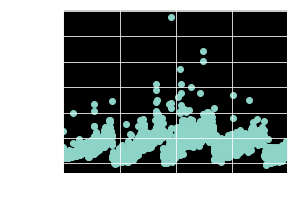

In [7]:
fig, ax = plt.subplots(figsize=(4, 3))

ax.scatter(range(size), t_sim)
ax.set_xlabel('Time Step')
ax.set_ylabel('Simulation time [s]')
ax.set_xlim(0, size)
ax.grid(True)

(<Figure size 1200x500 with 2 Axes>,
 <AxesSubplot:title={'center':'Bus Voltage'}, xlabel='Time [s]', ylabel='Voltage [p.u.]'>)

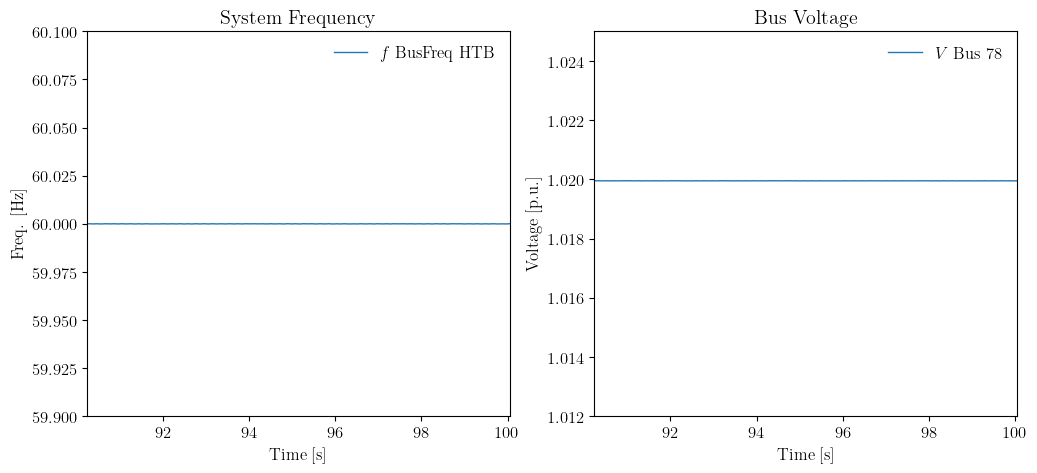

In [20]:
fig0, ax0 = plt.subplots(1, 2, figsize=(12, 5))

ss.TDS.plt.plot(ss.BusFreq.f,
                a=(0),
                ytimes=ss.config.freq,
                ylabel='Freq. [Hz]',
                ymin=59.9, ymax=60.1,
                title='System Frequency',
                ax=ax0[0], fig=fig0,
                show=False)

ss.TDS.plt.plot(ss.TDS.plt.find(f'v Bus {bus_htb}')[0][0],
                ylabel='Voltage [p.u.]',
                title='Bus Voltage',
                ax=ax0[1], fig=fig0,
                ymax=1.025, ymin=1.012,
                show=False)

(<Figure size 1200x500 with 2 Axes>,
 <AxesSubplot:title={'center':'Bus Voltage'}, xlabel='Time [s]', ylabel='Voltage [p.u.]'>)

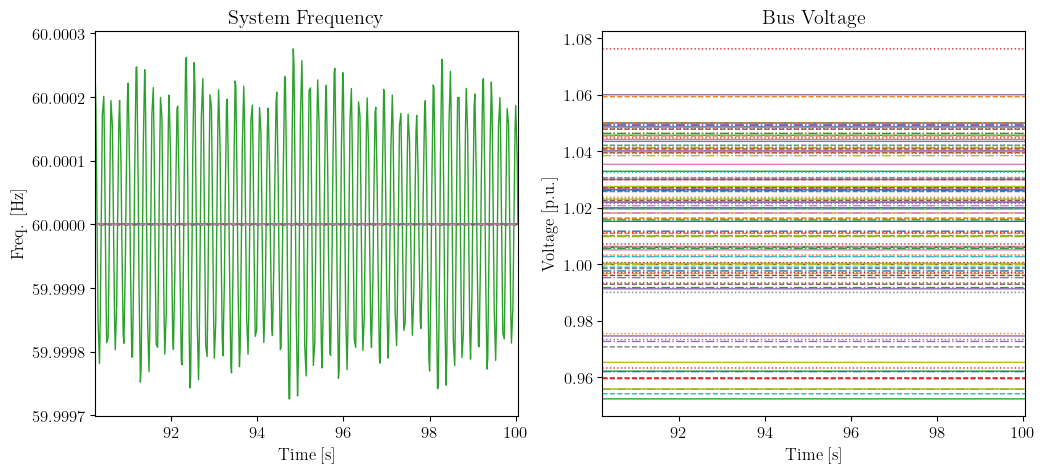

In [22]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

ss.TDS.plt.plot([ss.GENROU.omega, ss.GENCLS.omega],
                ytimes=ss.config.freq,
                ylabel='Freq. [Hz]',
                #                 ymin=59.998, ymax=60.002,
                title='System Frequency',
                ax=ax[0], fig=fig,
                show=False)
ss.TDS.plt.plot(ss.Bus.v,
                # ytimes=ss.config.mva,
                ylabel='Voltage [p.u.]',
                title='Bus Voltage',
                # a=(29),
                ax=ax[1], fig=fig,
                show=False)
